# 网络中的网络 NiN

<img src="./pic/网络中的网络.PNG" width=200 height=200>

## 全连接的问题

<img src="./pic/全连接的问题.PNG" width=500 height=500>

## NiN块

- 1x1卷积：按照每一个像素做的全连接层
<img src="./pic/NiN块.PNG" width=500 height=500>

## NiN架构

- 无全连接层
- 交替使用NiN块和步幅为2的最大池化层
    - 逐步减小高宽和增大通道数
- 最后使用全局平均池化层得到输出
     - 其输入通道数是类别数
     - 最后的通道数，就是类别数
     - 平均具有更好的鲁棒性
<img src="./pic/对比 VGG 和 NiN 及它们的块之间主要架构差异.PNG" width=500 height=500>

## 总结

- NiN块使用卷积层加两个1x1卷积层，
    - 后者对每个像素增加了非线性性
- NiN使用全局平均池化层来代替VGG和AlexNet中的全连接层
    - 不容易过拟合，更少的参数个数

In [2]:
import torch
from torch import nn
from d2l import torch as d2l


# 1x1卷积层相当于元素共享的全连接层
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),    # padding默认等于0，stride默认等于1
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU())

In [3]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=1),  # padding=0
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # 标签类别数是10
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),    # 全局平均池化层，高宽都是1
    # 将四维的输出转成二维的输出，其形状为(批量大小,10)
    nn.Flatten())

In [4]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


C:\Users\Tyler\anaconda3\envs\pytorch19\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss 0.353, train acc 0.868, test acc 0.878
1563.0 examples/sec on cuda:0


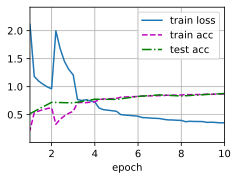

In [7]:
lr, num_epochs, batch_size = 0.01, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())    # softmax在training 函数里，所以不在net里

In [10]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

test_acc = evaluate_accuracy_gpu(net, test_iter, d2l.try_gpu())

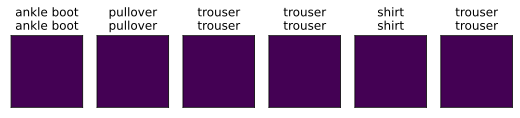

In [56]:
def predict_ch3(net, test_iter, device, n=6):
    for X, y in test_iter:
        break
    X, y = X.to(device), y.to(device)
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    X = X.cpu()
    d2l.show_images(X[0:n].reshape((n*64, 28, 28)), 1, n, titles=titles[0:n*64])

predict_ch3(net, test_iter, d2l.try_gpu())